In [52]:
import numpy as np
import math
from scipy.optimize import *
import matplotlib.pyplot as plt
import scipy

abcd total for the setup is:
[[-1.42500000e+00  3.63875000e+01]
 [-2.50000000e-03 -6.37916667e-01]]

The curve fit parameters for values of amplitude, x0 and wo are:
[1.09980377e+01 1.08951063e-01 3.08404989e-03]

qin of laser is:
47.20510331906346j

qout of telescope is:
(-36.29146593535718+112.1621866398889j)

waist, radius out of telescope is:
[0.04996557385079408, -382.93924627714773]

min waist out of telescope is:
0.047539012087521676




Lab 2b


abcd of cavity is:
[[0.06086888459033901, 49.8147489444364], [-0.02, 0.060868884590338956]]

The q_res of cavity is: (-0+49.90728994086595j)
waist cavity is: 0.3171092514143682 mm


q0 is : 44.6671941268691j

qin_tel is : (66.04+44.6671941268691j)

Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 19
         Function evaluations: 39


Telescope Length is : 62.87315368652344


abcd_tel is : 
[[-1.09577179e+00  6.28731537e+01]
 [ 1.04975382e-02 -1.51492615e+00]]
qout_tel is :(-16.9286162

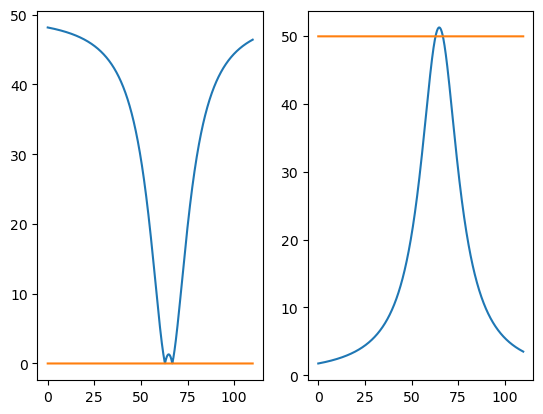

In [61]:
#in centimeters
from re import X


wavelength = 633*(10**-7)  # in cm

# Use this function to curvefit for power as a function of x to calculate w(z)
# IMPORTANT remmeber power is proportional to voltage measured on the oscilloscope
def power_as_func_of_x(x, amp, x0, waist):
    return (amp/2)*(1 + scipy.special.erf(np.sqrt(2)*(x-x0)/waist))

# Use this function to curvefit for waist as a function of z to calculate w0
# IMPORTANT, the parameters are in cm
def waist_as_func_of_z(z, w0, z0, b):
    return w0*np.sqrt(1+(((z-z0)**2)/(b**2)))

#alternate in terms of b
def waist_as_func_of_z_alt(z, z0, b):
    return b*np.sqrt(1+(((z-z0)**2)/(b**2)))/(np.pi) * wavelength

#calculate q for R and w
def calculate_q(radius_of_curvature,waist):
    return 1/(1/radius_of_curvature - 1j*wavelength/(np.pi*waist*waist))

#calculate w and R from q
def calculate_waist_radius_from_q(q_parameter):
    if(np.real(q_parameter) == 0):
        return [np.sqrt(-1*wavelength/(np.pi*np.imag(1/q_parameter) )),99999999999]
    else:
        return [np.sqrt(-1*wavelength/(np.pi*np.imag(1/q_parameter) )),1/np.real(1/q_parameter)]
# returns output q for input q and abcd
def calculate_q_out(qin, abcd):
    return (abcd[0][0]*qin + abcd[0][1])/(abcd[1][0]*qin + abcd[1][1])

#calculate q from w, R is infiniy
def calculate_q_from_waist(waist):
    return 1j*np.pi*waist*waist/wavelength





# ABCD parameters 
#length in cm
def abcd_free_space(length):
    return [[1,np.float64(length)],[0,1]]

#focal length in cm
def abcd_lens(focal_length):
    return [[1,0],[(-1/np.float64(focal_length)),1]]

#Radius of Curvature in cm, R +ve for concave, -ve for convex mirrors
def abcd_mirror(Roc):
    return [[1,0],[-2/np.float64(Roc), 1]]

#f and length in cm
def abcd_telescope(f_eye, f_obj, length):
    #print(abcd_lens(f_eye)@ abcd_free_space(length)@ abcd_lens(f_obj))
    array =  ((np.array(abcd_lens(np.float64(f_eye)))@ np.array(abcd_free_space(np.float64(length))) @np.array(abcd_lens(np.float64(f_obj)))))
    #print(array)
    return array.tolist()

# abcd for a cavity, all lengths in cm; Roc = 2*f
def abcd_cavity(l_big, l_small, Roc):
    l_diag = np.sqrt((l_big**2) + (l_small**2))
    array  = np.array(abcd_free_space(l_diag)) @ np.array(abcd_free_space(l_big)) @ np.array(abcd_mirror(Roc)) @ np.array(abcd_free_space(l_diag)) @ np.array(abcd_free_space(l_big))
    return array.tolist()


# calculate the resonance q for a SYMMETRIC bowtie cavity given the abcd matrix
def q_resonance_cavity(abcd_cavity):
    A = np.complex64(abcd_cavity[0][0])
    B = np.complex64(abcd_cavity[0][1])
    C = np.complex64(abcd_cavity[1][0])
    D = np.complex64(abcd_cavity[1][1])
    a = C
    b = D-A
    c = -1*B
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    #return ((a-d)/c + np.sqrt(-1*((d/c-a/c)**2) - 4*b/c))/2


# returns the absolute value of difference of b at the output of telescope and b for cavity, b is inversely proportional to the beam waist
def function_telescope_len_for_cavity(len_tel, f_obj, f_eye, q_in_tel, q_cavity):
    o = f_obj
    e = f_eye
    x = len_tel
    
    A = 1 - (x/o)
    B = x
    C = (-1*(1-(x/e))/o) - 1/e
    D = 1-(x/e)

    q_o_tel = (A*q_in_tel + B)/(C*q_in_tel + D)
    return abs(np.imag(q_o_tel) - np.imag(q_cavity))


# function to return the difference of 'b' at end of two telecopes and 'b' at the cavity. Can be minimized to find the coorect length  
def function_len_between_two_telescopes_for_cavity(len_bw_tel, f_obj_1,f_eye_1, f_obj_2, f_eye_2, q_in_tel_1, q_cavity):
    
    x  = np.float64(len_bw_tel)
    o1 = f_obj_1
    o2 = f_obj_2
    e1 = f_eye_1
    e2 = f_eye_2

    #print(abcd_telescope(e2,o2,e2+o2))
    #print("@@@@@@@@")
    #print(abcd_free_space(x))
    #print("@@@@@@@@")
    #print(abcd_telescope(e1,o1,e1+o1))
    #print(np.array(abcd_telescope(e2,o2,e2+o2)))
    #print("########")
    #print(np.array(abcd_free_space(x)))
    #print("########")
    #print(np.array(abcd_telescope(e1,o1,e1+o1)))
    _array = (np.array(abcd_telescope(e2,o2,e2+o2)) @ np.array(abcd_free_space(x)) @ np.array(abcd_telescope(e1,o1,e1+o1)))
    _abcd_total = _array.tolist()
    
    #print(_array)
    #print(_abcd_total)
    _q_o_tel_2 = calculate_q_out(q_in_tel_1,_abcd_total)

    #print("#########\n Debugging \n q_out_tel_2 : " + str(_q_o_tel_2) + " q_cavity : "+str(q_cavity))

    return abs(np.imag(_q_o_tel_2) - np.imag(q_cavity))

# function to return the difference of 'b' at end of one telecope and a lens and 'b' at the cavity. Can be minimized to find the coorect length 
def function_len_between_telescope_and_lens(len_bw_tel_lens, f_obj, f_eye, len_telescope, f_lens, q_in_tel, q_cavity):
    x = np.float64(len_bw_tel_lens)
    o = f_obj
    e = f_eye
    u = f_lens
    l = len_telescope

    A = (-o*x + o*e + x*l - x*e - l*e)/(o*e)
    B = (-x*l + x*e + l*e)/e
    C = -(u*o - u*l + u*e - o*x + o*e + x*l - x*e - l*e)/(u*o*e)
    D = (-u*l + u*e + x*l - x*e - l*e)/(u*e)

    _q_o_tel = (A*q_in_tel + B)/(C*q_in_tel + D)
    return abs(np.imag(_q_o_tel) - np.imag(q_cavity))







'''
Lab 2a code here
'''
#print(np.array(abcd_free_space(30))@np.array(abcd_free_space(10)))
#print(abcd_telescope(30,20,48.5))
abcd_total = np.array(abcd_telescope(30,20,48.5))@np.array(abcd_free_space(8.5))
print("abcd total for the setup is:")
print(abcd_total)

#print(abcd_total)





''' 
    curve fitting
'''

x_val = [0.1, 0.104, 0.108, 0.112, 0.116]
volt_val = [0.630, 1.233, 2.938, 10.784, 10.953]



guess_power_x = []  #[amp, x0, waist]; x0 is the centre of beam

####### UNCOMMENT  #######
#plt.plot(x_val,volt_val)
popt0,pcov0 = curve_fit(power_as_func_of_x,x_val,volt_val)

#print(popt0)
dummy_x = np.arange(0.1,0.12,0.001)
#plt.plot(dummy_x,power_as_func_of_x(dummy_x,*popt0))

print("\nThe curve fit parameters for values of amplitude, x0 and wo are:")
print(popt0)

z_val = []
waist_val = []

guess_waist_as_func_of_z = []   # [w0 , z0, b] in cm

#plt.plot(z_val,waist_val)
#popt1,pcov1 = curve_fit(waist_as_func_of_z,z_val,waist_val,guess_waist_as_func_of_z)
#plt.plot(z_val,waist_as_func_of_z(z_val,*popt1))


qin = calculate_q_from_waist(0.0308404989)
print("\nqin of laser is:")
print(qin)

qout_telescope = calculate_q_out(qin,abcd_total)


print("\nqout of telescope is:")
print(qout_telescope)

waist_telecope = calculate_waist_radius_from_q(qout_telescope)

print("\nwaist, radius out of telescope is:")
print(waist_telecope)

waist_min = calculate_waist_radius_from_q(112.1621866398889j)[0]
print("\nmin waist out of telescope is:")
print(waist_min)




''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


'''
Lab 2b code here
'''
print("\n\n\n\nLab 2b")



# parameterize the setup

len_before_telescope = 26  #inches

f_obj = 30  #cm
f_eye = 25   #cm

Roc   = 100  #cm

cav_big_arm   = 9   #inches
cav_small_arm = 3   #inches


#####################

print("\n\nabcd of cavity is:")
abcd_cav = abcd_cavity(cav_big_arm*2.54,cav_small_arm*2.54,Roc)
print(abcd_cav)


q_res = q_resonance_cavity(abcd_cav)
print("\nThe q_res of cavity is: "+ str(q_res))

w_cavity = calculate_waist_radius_from_q(q_res)[0]
print("waist cavity is: "+str(w_cavity*10)+" mm")


q0 = calculate_q(9999999999999999, 0.03)
print("\n\nq0 is : "+str(1j*np.imag(q0))+"\n")
qin_telescope = calculate_q_out(1j*np.imag(q0),abcd_free_space(len_before_telescope*2.54))
print("qin_tel is : "+str(qin_telescope)+"\n")

#args_cavity = [f_obj,f_eye,qin_telescope,q_res]
args_cavity = [f_obj,f_eye,qin_telescope,q_res]

def function_telescope_len_for_cavity_with_args(x):
    return function_telescope_len_for_cavity(x, *args_cavity )

tel_len = scipy.optimize.fmin( function_telescope_len_for_cavity_with_args, 50)[0]

print("\n\nTelescope Length is : " + str(tel_len)+"\n\n")
x_val = np.arange(0,2*(f_obj+f_eye),0.1)
def y_0(x):
    return 0*x

subplot_lab2b_1 = plt.subplot(1,2,1)
subplot_lab2b_1.plot(x_val,function_telescope_len_for_cavity_with_args(x_val))
subplot_lab2b_1.plot(x_val,y_0(x_val))

#print(function_telescope_len_for_cavity_with_args(tel_len))
#abcd_tel = abcd_telescope(f_eye,f_obj,tel_len)
abcd_tel = abcd_telescope(f_eye,f_obj,tel_len)
print("abcd_tel is : \n" + str(np.array(abcd_tel)))
qout_tel = calculate_q_out(qin_telescope,abcd_tel)
print('qout_tel is :' + str(qout_tel)+"\n")
waist_tel = calculate_waist_radius_from_q(1j*np.imag(qout_tel))
print('waist_tel is :' + str(waist_tel[0]*10)+" mm\n")


def function_b_out_tel(x):
    _abcd = abcd_telescope(f_eye, f_obj, np.float64(x))
    _q_out = calculate_q_out(qin_telescope,_abcd)

    return np.imag(_q_out)

subplot_lab2b_2 = plt.subplot(1,2,2)
y3 = []
for x in x_val:
    y3.append(function_b_out_tel(x))
subplot_lab2b_2.plot(x_val,y3)
subplot_lab2b_2.plot(x_val,np.absolute(q_res)+0*x_val)


'''  

#Uncomment for alternate code.

#    Alternate setup with two telescopes

f_obj_1 = 30  #cm
f_eye_1 = 25   #cm

f_obj_2 = 10  #cm
f_eye_2 = 5   #cm

args_cavity_two_telescope = [f_obj_1, f_eye_1, f_obj_2, f_eye_2, qin_telescope, q_res]

def function_len_between_two_telescopes_for_cavity_with_args(x):
    return function_len_between_two_telescopes_for_cavity(x,*args_cavity_two_telescope)

len_between_telescope = scipy.optimize.fmin( function_len_between_two_telescopes_for_cavity_with_args, 50)[0]

print("The length between two telescopes is: " + str(len_before_telescope))

y_val = []
subplot_lab2b_2 = plt.subplot(1,2,2)
for x in x_val:
    y_val.append(function_len_between_two_telescopes_for_cavity_with_args(x))
    
#print('@@@@@@@@@')
#print(y_val)
subplot_lab2b_2.plot(x_val,function_len_between_two_telescopes_for_cavity_with_args(x_val))
#subplot_lab2b_2.plot(x_val,y_0(x_val))

print('\n Length between the telescopes is: ' + str(len_between_telescope))

def function_len_between_two_telescopes_for_cavity_q(len_bw_tel, f_obj_1,f_eye_1, f_obj_2, f_eye_2, q_in_tel_1, q_cavity):
    
    x  = np.float64(len_bw_tel)
    o1 = f_obj_1
    o2 = f_obj_2
    e1 = f_eye_1
    e2 = f_eye_2

    #print(abcd_telescope(e2,o2,e2+o2))
    #print(abcd_free_space(x))
    #print(abcd_telescope(e1,o1,e1+o1))
    #print(np.array(abcd_telescope(e2,o2,e2+o2)))
    #print(np.array(abcd_free_space(x)))
    #print(np.array(abcd_telescope(e1,o1,e1+o1)))
    _array = (np.array(abcd_telescope(e2,o2,e2+o2)) @ np.array(abcd_free_space(x)) @ np.array(abcd_telescope(e1,o1,e1+o1)))
    _abcd_total = _array.tolist()
    
    #print(_array)
    #print(_abcd_total)
    _q_o_tel_2 = calculate_q_out(q_in_tel_1,_abcd_total)

    #print("#########\n Debugging \n q_out_tel_2 : " + str(_q_o_tel_2) + " q_cavity : "+str(q_cavity))

    return np.imag(_q_o_tel_2)

subplot2 = plt.subplot(1,1,1)
subplot2.plot(x_val,function_len_between_two_telescopes_for_cavity_q(x_val,*args_cavity_two_telescope))




#Alternate 2 Lens + telescope


f_lens = 15

args_cavity_telescope_lens = [f_obj,f_eye,tel_len,f_lens,qin_telescope,q_res]
def function_len_between_telescope_and_lens_with_args(x):
    return(function_len_between_telescope_and_lens(x,*args_cavity_telescope_lens))

len_between_telescope_lens = scipy.optimize.fmin(function_len_between_telescope_and_lens_with_args,10)[0]
print("The length between telescope and lens is : "+str(len_between_telescope_lens))
abcd_lens_telescope = (np.array(abcd_lens(f_lens)) @ np.array(abcd_free_space(len_between_telescope_lens)) @ np.array(abcd_telescope(f_eye, f_obj, tel_len))).tolist()

def func_qout_tel_lens_imaginary(x):
    _abcd_lens_telescope = (np.array(abcd_lens(f_lens)) @ np.array(abcd_free_space(x)) @ np.array(abcd_telescope(f_eye, f_obj, tel_len))).tolist()

    return np.imag(calculate_q_out(qin_telescope,_abcd_lens_telescope))

print(abcd_lens_telescope)

qout_tel_lens = calculate_q_out(qin_telescope,abcd_lens_telescope)
print("qout_lens is : "+ str(qout_tel_lens))

fig = plt.subplot(1,1,1)
#fig.plot(x_val,function_len_between_telescope_and_lens_with_args(x_val))
fig.plot(x_val,func_qout_tel_lens_imaginary(x_val))

'''

#verification of abcd matrix, manually
abcd_temp = [[-1.09577, -9.49143], [0.0104973, -0.821676]]

print(calculate_q_out(1j*np.imag(q0),abcd_temp))
